In [126]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pylab
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

In [2]:
from sklearn import datasets as ds

df = ds.fetch_openml(data_id=151,as_frame=True, return_X_y=True)

# Introdução

O seguinte trabalho trata sobre o preço da eletricidade nas cidades australianas de New South Whale e Victoria (referidas como NSW e VIC, respectivamente). Nesse mercado em questão os preços não são fixados, flutuam a cada 5 minutos e são afetados pela oferta e demanda. O dataset a seguir traz essas variações a cada 30 minutos e uma label nos informando se nesse período o preço em NSW subiu (UP) ou desceu (DOWN). 

O intuito do presente trabalho é criar um modelo em ML que possa predizer de maneira adequado o comportamento do preço (UP/DOWN) e quais variáveis dependentes são as principais influenciadoras nesse comportamento.

## Informações sobre o dataset

**date:** *data entre 8 de maio de 1996 e 5 de dezembro de 1998. Padronizadas entre 0 e 1.*  
**day:** *dia da semana (1-7).*  
**period:** *hora da medição (1-48) a cada 30 minutos em um intervalo de 1 dia (24 horas). Padronizado entre 0 e 1.*  
**nswprice:** *preço da eletricidade em New South Wale. Padronizado entre 0 e 1.*  
**nswdemand:** *demanda da eletricidade em New South Wale. Padronizado entre 0 e 1.*  
**vicprice:** *preço da eletricidade em Victoria. Padronizado entre 0 e 1.*  
**vicdemand:** *demanda da eletricidade em Victoria. Padronizado entre 0 e 1.* 
**transfer:** *transferência agendada de eletricidade entre as duas cidades. Padronizado entre 0 e 1.*  
**class:** *variável categórica. UP: Preço da eletricidade em NSW maior que a média das últimas 24h. Down: caso contrário.*  
**target:** *representação numérica da variável class. 1:UP, 2:DOWN*

Papers relevantes:
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

[FONTE](https://www.openml.org/search?type=data&sort=runs&status=active&id=151)


In [3]:
df = (

    pd.concat(df, axis=1)

    .assign(target=lambda x: (x['class']=='UP')*1)

)

# Dados

## Tabela dos dados

In [4]:
df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class,target
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP,1
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP,1
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP,1
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP,1
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,0


In [5]:
nswprice = df.nswprice
nswdemand = df.nswdemand
vicprice = df.vicprice
vicdemand = df.vicdemand

## Estrutura dos dados

In [6]:
print(f'Estrutura dos dados: {df.shape}')

# Estatísticas descritivas para cada coluna
print('')
df[['nswprice','nswdemand','vicprice','vicdemand','transfer']].describe()

Estrutura dos dados: (45312, 10)



,nswprice,nswdemand,vicprice,vicdemand,transfer
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.057868,0.425418,0.003467,0.422915,0.500526
std,0.039991,0.163323,0.010213,0.120965,0.153373
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.035127,0.309134,0.002277,0.372346,0.414912
50%,0.048652,0.443693,0.003467,0.422915,0.414912
75%,0.074336,0.536001,0.003467,0.469252,0.605702
max,1.000000,1.000000,1.000000,1.000000,1.000000


É possível observar que o preço em NSW é em media 16.69x maior que em VIC, apesar da demanda média ser parecida. Pode-se observar também que a distribuição dos preços em VIC está bem centrada em torno da sua média, o que leva a crer que uma boa estimativa pontual para o preço em VIC seria a própria média amostral.

In [7]:
df.dtypes

date          float64
day          category
period        float64
nswprice      float64
nswdemand     float64
vicprice      float64
vicdemand     float64
transfer      float64
class        category
target          int32
dtype: object

In [8]:
#df['period'] = df['period'].astype('category')

In [9]:
df.isnull().sum().sum()

0

Transformando as variáveis day e period em dummies, para que seus valores numéricos não influenciem na análise. A feature class foi excluída do dataset, pois a variável target é sua representação númerica (1=UP, 0=DOWN).

In [10]:
#df2 = df.drop('class', axis=1)
#df2 = pd.get_dummies(df2, drop_first=False)

#column_class = df['class']
#df2 = pd.concat([df2,column_class], axis = 1)
#df = df2
#del(df2)
#df.head()

## Gráfico das Séries

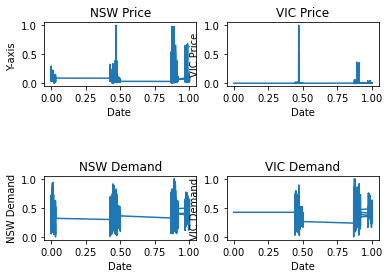

In [11]:
plt.subplot(3, 2, 1)
plt.plot(df.date, nswprice)
plt.title("NSW Price")
plt.xlabel('Date ')
plt.ylabel('Y-axis ')


plt.subplot(3, 2, 2)
plt.plot(df.date, vicprice)
plt.title("VIC Price")
plt.xlabel('Date')
plt.ylabel('VIC Price')

plt.subplot(3, 2, 5)
plt.plot(df.date, nswdemand)
plt.title("NSW Demand")
plt.xlabel('Date')
plt.ylabel('NSW Demand')

plt.subplot(3, 2, 6)
plt.plot(df.date, vicdemand)
plt.title("VIC Demand")
plt.xlabel('Date')
plt.ylabel('VIC Demand')

plt.show()

## Matriz de Correlação

In [12]:
df
df2 = df[['nswprice','nswdemand','vicprice','vicdemand','transfer']]

In [13]:
df2.corr()

,nswprice,nswdemand,vicprice,vicdemand,transfer
nswprice,1.000000,0.304952,0.286072,0.307275,-0.275001
nswdemand,0.304952,1.000000,0.086393,0.668501,-0.267897
vicprice,0.286072,0.086393,1.000000,0.127553,-0.084166
vicdemand,0.307275,0.668501,0.127553,1.000000,-0.555525
transfer,-0.275001,-0.267897,-0.084166,-0.555525,1.000000


A única correlação linear forte é entre a demanda em NSW e VIC. A seguir o scatter plot entre as duas variáveis.

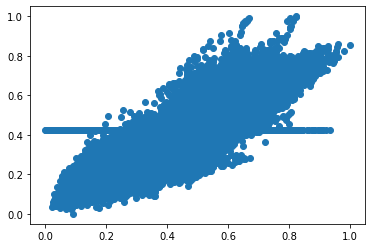

In [14]:
plt.scatter(nswdemand,vicdemand)

Apesar de não ter uma alta correlação linear, 

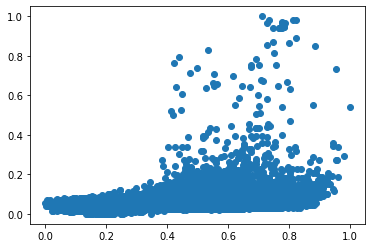

In [15]:
plt.scatter(x=nswdemand,y=nswprice)

Preços maiores parecem aparecer apenas para demandas acima de 0.4 e os maiores preços estão ligados a períodos a de alta demanda.
Abaixo gráficos do preço e demanda médios ao longo do tempo.

In [16]:
## Testando Normalidade nas variáveis

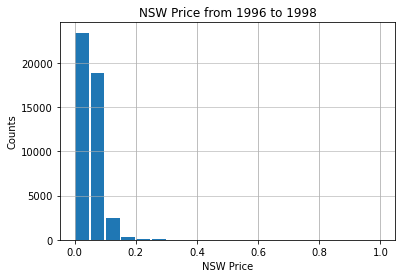

In [17]:
df.nswprice.plot.hist(grid=True,bins=20,rwidth=0.9)
plt.title('NSW Price from 1996 to 1998')
plt.ylabel('Counts')
plt.xlabel('NSW Price')
plt.grid(axis='y', alpha=0.75)

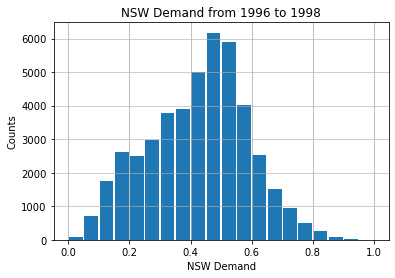

In [18]:
df.nswdemand.plot.hist(grid=True,bins=20,rwidth=0.9)
plt.title('NSW Demand from 1996 to 1998')
plt.ylabel('Counts')
plt.xlabel('NSW Demand')
plt.grid(axis='y', alpha=0.75)

Text(0.5, 0, 'NSW Demand')

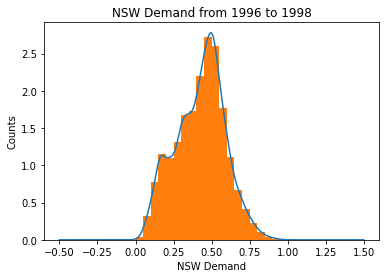

In [19]:
fig, ax = plt.subplots()
df.nswdemand.plot.kde(ax=ax, legend=False, title='NSW Demand from 1996 to 1998')
df.nswdemand.plot.hist(density=True, ax=ax,bins=20)
plt.ylabel('Counts')
plt.xlabel('NSW Demand')

<AxesSubplot:xlabel='nswprice', ylabel='Count'>

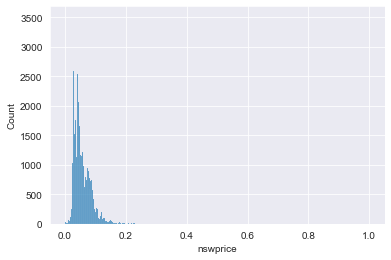

In [20]:
sns.set_style('darkgrid')
sns.histplot(df.nswprice)

<AxesSubplot:xlabel='vicprice', ylabel='Count'>

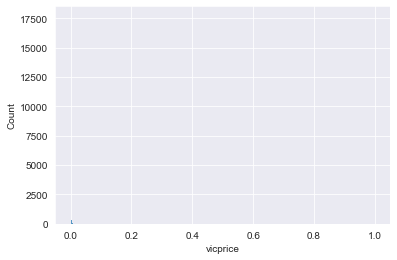

In [21]:
sns.set_style('darkgrid')
sns.histplot(df.vicprice)

<AxesSubplot:xlabel='nswdemand', ylabel='Count'>

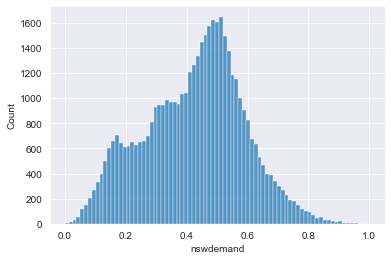

In [22]:
sns.histplot(df.nswdemand)

<AxesSubplot:xlabel='vicdemand', ylabel='Count'>

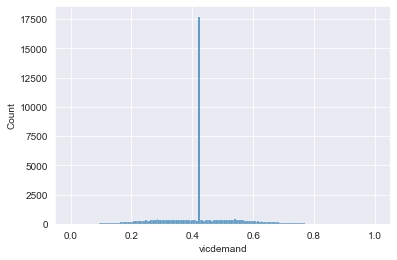

In [23]:
sns.histplot(df.vicdemand)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.      , 0.      , ..., 0.981806, 0.981806, 1.      ])),
 (0.030221145123102266, 0.05786831013859463, 0.7556428703662484))

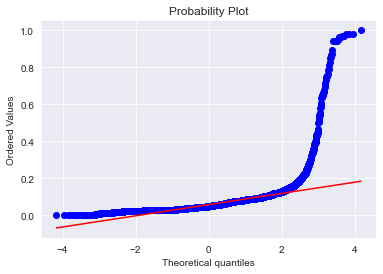

In [24]:
stats.probplot(df.nswprice, dist="norm", plot=pylab)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.00119 , 0.001488, ..., 0.962511, 0.980809, 1.      ])),
 (0.16255185534600416, 0.4254178952595338, 0.9952009223530537))

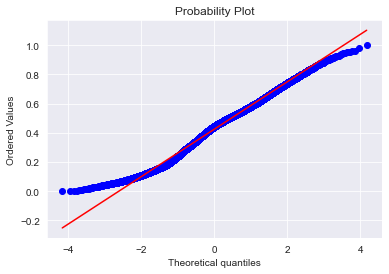

In [25]:
stats.probplot(df.nswdemand, dist="norm", plot=pylab)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.      , 0.      , ..., 0.980682, 0.996228, 1.      ])),
 (0.002040413599105342, 0.0034670338983050835, 0.1997692688809712))

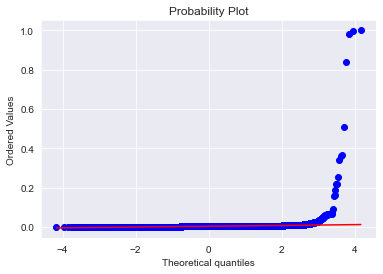

In [26]:
stats.probplot(df.vicprice, dist="norm", plot=pylab)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.024081, 0.025634, ..., 0.991196, 0.996893, 1.      ])),
 (0.1174331447804295, 0.42291507571945613, 0.9707226174261446))

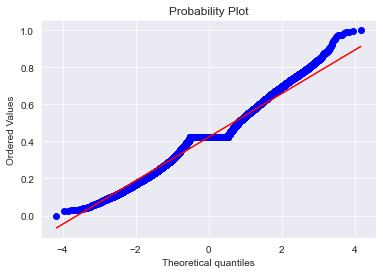

In [27]:
stats.probplot(df.vicdemand, dist="norm", plot=pylab)

In [28]:
df

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class,target
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP,1
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP,1
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP,1
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP,1
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,0
...,...,...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,DOWN,0
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,DOWN,0
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,DOWN,0
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,UP,1


# Classificação através de modelos de Machine Learning

In [53]:
X = df.drop(["date","nswprice","class","target"],axis=1)
X = X.values
y = df[['target']]
print(y.value_counts())
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

target
0         26075
1         19237
dtype: int64


## Regressão Logística

In [92]:
log_regression = LogisticRegression()
log_regression.fit(X_train,y_train.ravel())

LogisticRegression()

In [93]:
y_pred = log_regression.predict(X_test)

# Accuracy
accuracy_score(y_test, y_pred)

0.6474915403854642

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      7873
           1       0.59      0.52      0.55      5721

    accuracy                           0.65     13594
   macro avg       0.64      0.63      0.63     13594
weighted avg       0.64      0.65      0.64     13594



### Curva ROC

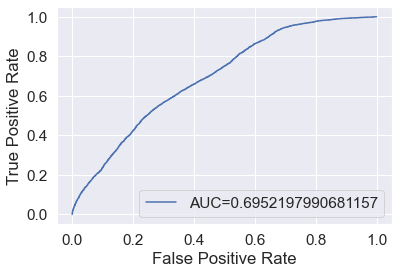

In [56]:
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## K Nearest Neighbors (KNN)

Rondando com 5 vizinhos (arbitrário)

In [90]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,y_train.ravel())

y_pred = model.predict(X_test)

0.7139179049580697

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.75      7873
           1       0.66      0.65      0.66      5721

    accuracy                           0.71     13594
   macro avg       0.71      0.71      0.71     13594
weighted avg       0.71      0.71      0.71     13594



### Curva ROC

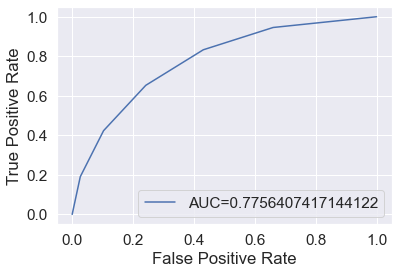

In [59]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Procurando o melhor valor para K, utilizando algoritmo GridSearchCV

In [95]:
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 15)} # rodei 1 a 50 .. resultado 5 .. diminui para nao demorar muito quando rodasse novamente
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train.ravel())
gridsearch.best_params_

{'n_neighbors': 13}

In [115]:
y_pred_grid = gridsearch.predict(X_test)

print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      7873
           1       0.67      0.65      0.66      5721

    accuracy                           0.72     13594
   macro avg       0.71      0.71      0.71     13594
weighted avg       0.72      0.72      0.72     13594



É possível perceber uma melhora na acurácia do modelo (de 0.71 para 0.72), e também no f1-score para o target 0.  


Adicionando peso as distancias e verificando se existe uma melhora no modelo (é necessário verificar novamente o melhor número para K, pois ao adicionar peso as distancias ele pode mudar).

In [99]:
parameters = {
    "n_neighbors": range(1, 15),
    "weights": ["uniform", "distance"],
}

gridsearch2 = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch2.fit(X_train, y_train.ravel())

gridsearch2.best_params_

{'n_neighbors': 13, 'weights': 'uniform'}

In [100]:
y_pred_grid2 = gridsearch2.predict(X_test)

print(classification_report(y_test, y_pred_grid2))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      7873
           1       0.67      0.65      0.66      5721

    accuracy                           0.72     13594
   macro avg       0.71      0.71      0.71     13594
weighted avg       0.72      0.72      0.72     13594



Não houve melhora na acurácia do modelo ao adicionar peso as distancias. 

### Curva ROC

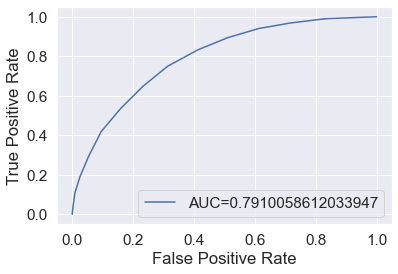

In [79]:
y_pred_proba = gridsearch.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Parece o limite do KNN. Decidiu-se seguir a análise com um novo algoritmo e ver se é possível obter um melhor modelo de classificação.

## Random Forest

In [101]:
# Importando o modelo
from sklearn.ensemble import RandomForestClassifier

# Instanciando modelo com 900 arvores
rf = RandomForestClassifier(n_estimators = 900, random_state = 0)

# Treinando o modelo nas amostras de treino
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(n_estimators=900, random_state=0)

In [103]:
# Predição na amostra de teste
y_pred = rf.predict(X_test)

#Report de Acurácia
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      7873
           1       0.73      0.70      0.71      5721

    accuracy                           0.76     13594
   macro avg       0.76      0.76      0.76     13594
weighted avg       0.76      0.76      0.76     13594



Melhora significativa na predição em relação aos modelos anteriores.

### Matriz de Confusão

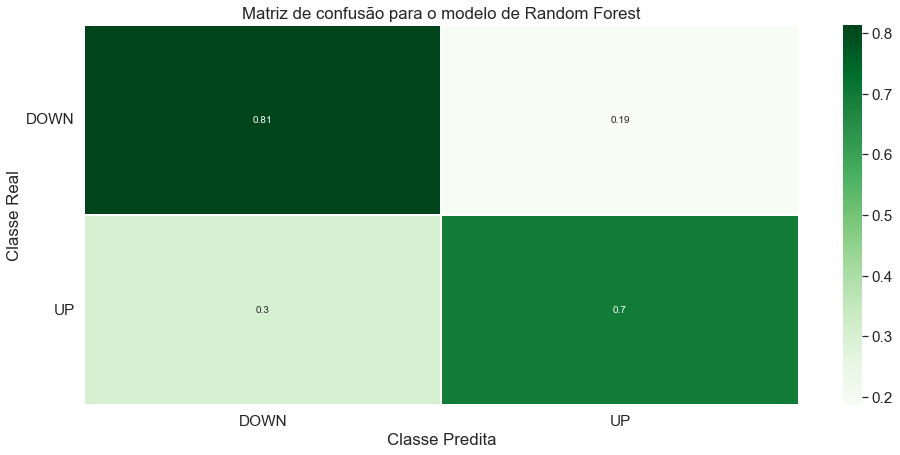

In [106]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
# Add labels to the plot
class_names = ['DOWN', 'UP']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de confusão para o modelo de Random Forest')
plt.show()

### Curva ROC

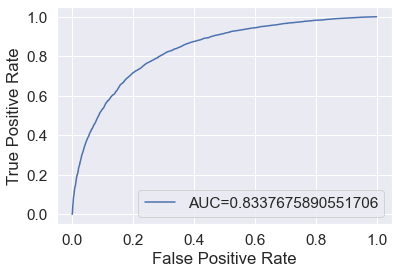

In [107]:
y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Segundo a literatura, um AUC (área abaixo da curva ROC) entre 0.8 e 0.9 é considerado excelente.  
(Hosmer and Lemeshow em [Applied Logistic Regression, p. 177](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118548387))

O trabalho seguiu com tentativas de melhorar o modelo.

Após inumeras tentativas chegou-se ao seguinte modelo:  
**Nº de árvores:** 900    
**Nº máximo de atributos em cada árvore:** 5  
**Critério do split:** entropia

In [108]:
# Instantiate model with 900 decision trees
rf = RandomForestClassifier(n_estimators = 900, random_state = 0, criterion='entropy', max_features = 5) 

# Train the model on training data
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=900,
                       random_state=0)

In [111]:
# Predição
y_pred = rf.predict(X_test)

# Report de Acurácia
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      7873
           1       0.74      0.70      0.72      5721

    accuracy                           0.77     13594
   macro avg       0.76      0.76      0.76     13594
weighted avg       0.77      0.77      0.77     13594



### Importância dos atributos no modelo

In [117]:
#m = rf.feature_importances_
headers = ['day','period','nswdemand','vicprice','vicdemand','transfer']
headers = np.array(headers)

#from prettytable import PrettyTable

#x = PrettyTable(headers)
#x.add_row(m)



array([0.08026202, 0.15215361, 0.38330578, 0.1876476 , 0.10182899,
       0.094802  ])

In [116]:
help(RandomForestClassifier)


Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  P

In [142]:
rf.oob_score

False

A demanda em NSW foi o atributo mais importante para o modelo, explicando 38.33% da variância dos dados.  
Seguido por preço da energia em Victoria (18.76%), período do dia (15.21%), demanda em Victoria (10.18%),datas agendadas para transferência de energia entre as duas cidades (9.48%) e dia da semana (8.02%).

Text(0.5, 1.0, 'Importância dos Atributos')

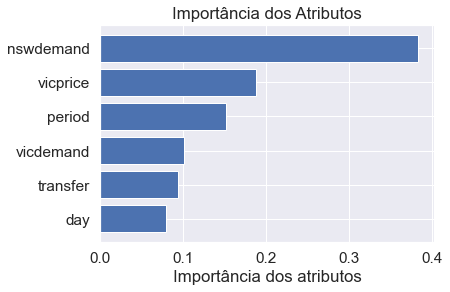

In [141]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(headers[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Importância dos atributos")
plt.title("Importância dos Atributos")

In [ ]:
perm_importance = permutation_importance(rf, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

Text(0.5, 1.0, 'Importância dos Atributos (permutação)')

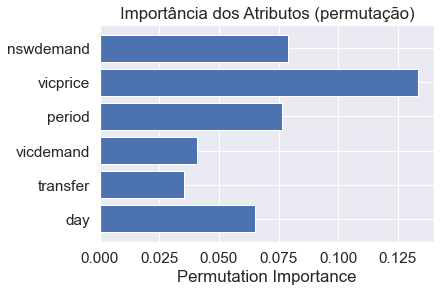

In [140]:
plt.barh(headers[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Importância dos Atributos (permutação)")

Text(0.5, 0, 'Permutation Importance')

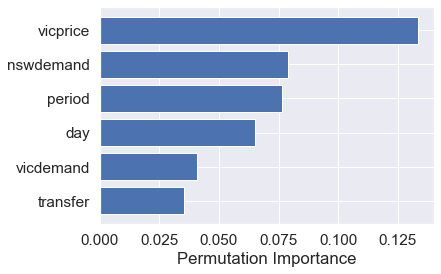

In [120]:
help(plt.barh)

Help on function barh in module matplotlib.pyplot:

barh(y, width, height=0.8, left=None, *, align='center', **kwargs)
    Make a horizontal bar plot.
    
    The bars are positioned at *y* with the given *align*\ment. Their
    dimensions are given by *width* and *height*. The horizontal baseline
    is *left* (default 0).
    
    Many parameters can take either a single value applying to all bars
    or a sequence of values, one for each bar.
    
    Parameters
    ----------
    y : float or array-like
        The y coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    width : float or array-like
        The width(s) of the bars.
    
    height : float or array-like, default: 0.8
        The heights of the bars.
    
    left : float or array-like, default: 0
        The x coordinates of the left sides of the bars.
    
    align : {'center', 'edge'}, default: 'center'
        Alignment of the base to the *y* coordinates*:
 

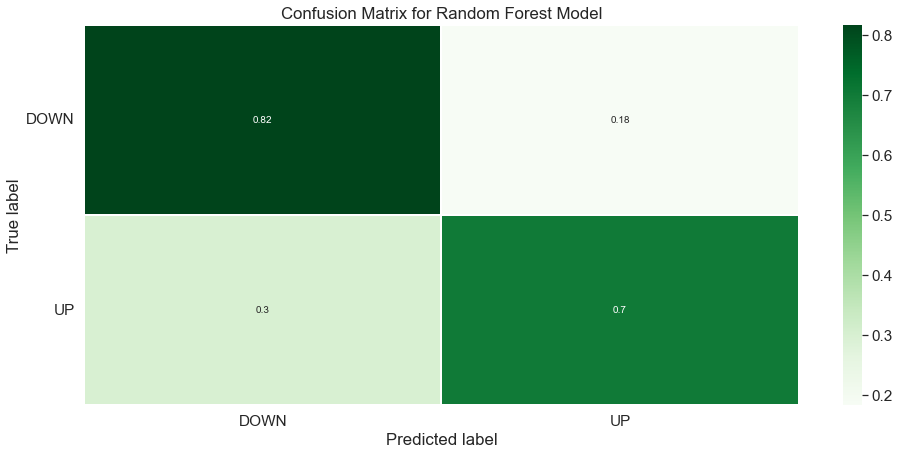

In [72]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
# Add labels to the plot
class_names = ['DOWN', 'UP']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      7873
           1       0.74      0.70      0.72      5721

    accuracy                           0.77     13594
   macro avg       0.76      0.76      0.76     13594
weighted avg       0.77      0.77      0.77     13594



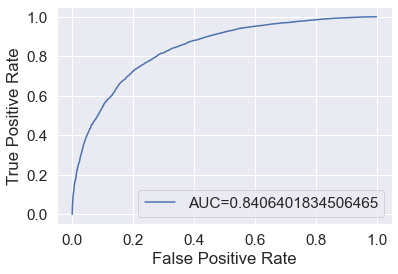

In [74]:
y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()